In [1]:
import polars as pl
import datetime as dt
import inference.model_functions as modeling
from pathlib import Path

# Set up model path
model_dir = Path('Models')
date = dt.date.today().strftime('%Y-%m-%d')
target_dir = model_dir/date
target_dir.mkdir(parents=True,exist_ok=True)

# Set up data path
data_dir = Path('data')
data_dir = data_dir/date
import_path = data_dir/"starter_model_dataset.parquet"



In [2]:
dataset = pl.read_parquet(import_path)

In [3]:
model_data = modeling.preprocess_data(df=dataset, target_col='lapsed_flag')

Encoding categorical columns:
  - p1_emp_status: 11 unique values
  - p1_mar_status: 10 unique values
  - p1_sex: 3 unique values
  - occ_status: 7 unique values
  - payment_method: 3 unique values


In [4]:
X_train, X_test, y_train, y_test, feature_cols = modeling.prepare_modeling_data(model_data)

Dataset prepared:
  Total samples: 189,005
  Features: 40
  Target distribution:
    Not Lapsed (0): 136,471 (72.2%)
    Lapsed (1): 52,534 (27.8%)
  Imbalance ratio: 2.6:1

Train set: 151,204 samples
  Not Lapsed: 109,177 (72.2%)
  Lapsed: 42,027 (27.8%)

Test set: 37,801 samples
  Not Lapsed: 27,294 (72.2%)
  Lapsed: 10,507 (27.8%)


In [5]:
weighting = modeling.calculate_class_weights(y_train)

CLASS WEIGHT CALCULATION
scale_pos_weight: 2.60

This makes the model 2.6x more sensitive to lapse


In [6]:
def xgb_pipeline(X_train, y_train, X_test, y_test, scale_pos_weight):
    xgb = modeling.train_xgboost(X_train, y_train, scale_pos_weight=scale_pos_weight, 
                    use_cv=True, random_state=42)
    evaluations = modeling.evaluate_model(xgb, X_test, y_test, model_name="XGB", threshold=0.5)
    importance_df = modeling.analyze_feature_importance(xgb, feature_cols)
    return xgb, evaluations, importance_df


TRAINING XGBOOST
Using scale_pos_weight=2.60

Running 5-fold CV...
CV AUC: 0.7495 (+/- 0.0035)
✅ Training complete

EVALUATING XGB
  AUC-ROC: 0.7518
  Average Precision: 0.5752
  Threshold: 0.50
                Predicted
                No    Yes
Actual No     19362    7932
       Yes     3633    6874
  Precision: 0.464 (of flagged, % actually lapsed)
  Recall: 0.654 (% of lapses caught)
  F1-Score: 0.543
  Specificity: 0.709

  True Positives: 6,874 (caught lapses)
  False Positives: 7,932 (false alarms)
  False Negatives: 3,633 (missed lapses)
  True Negatives: 19,362
  Optimal threshold (f1): 0.50
  Score at optimal: 0.543
  At 0.50: catch 6874/10507 lapses, 7932 false alarms
  At 0.50: catch 6874/10507 lapses, 7932 false alarms

FEATURE IMPORTANCE

Top 20 Features:
shape: (20, 4)
┌───────────────────────┬────────────┬───────────────────────┬────────────────┐
│ feature               ┆ importance ┆ cumulative_importance ┆ cumulative_pct │
│ ---                   ┆ ---        ┆ ---  

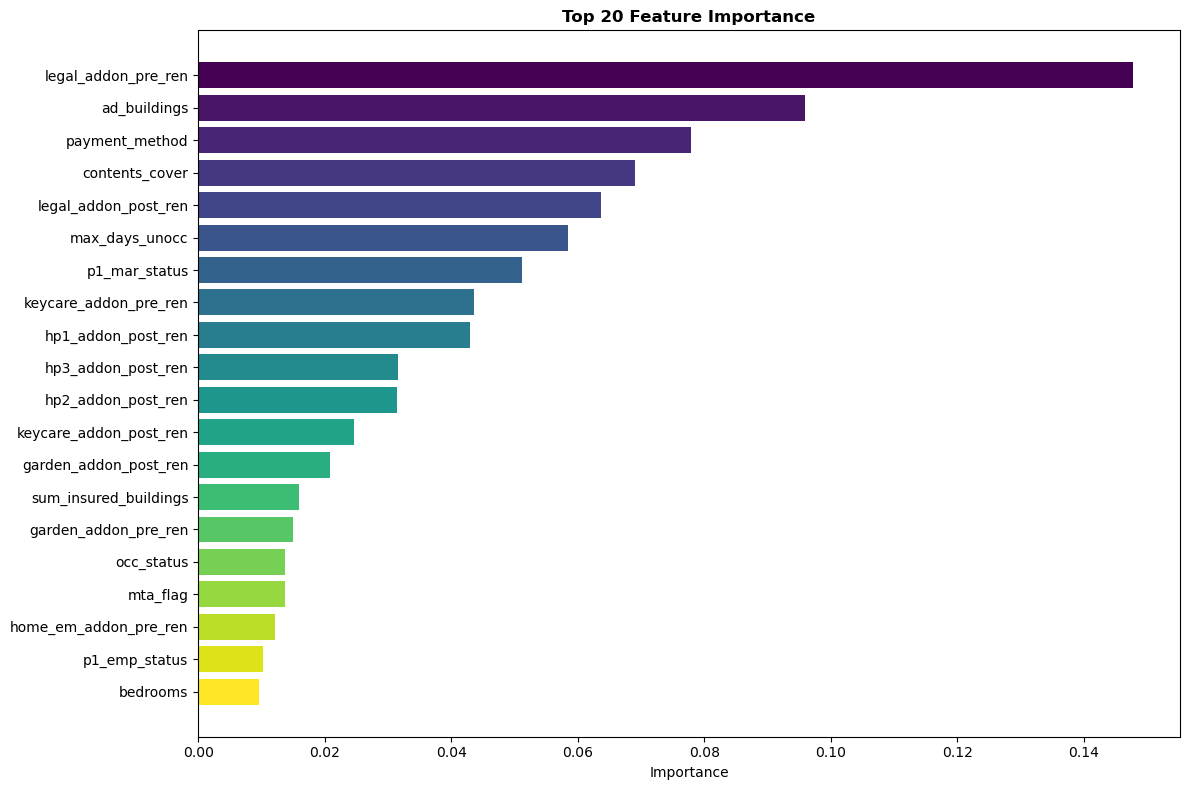

In [7]:
xgb, evals, importance = xgb_pipeline(X_train, y_train, X_test, y_test, weighting)

In [8]:
lgb = modeling.train_lightgbm(X_train, y_train, scale_pos_weight=weighting, 
                  use_cv=True, random_state=42)


TRAINING LIGHTGBM
Using scale_pos_weight=2.60

Running 5-fold CV...
CV AUC: 0.7496 (+/- 0.0035)
✅ Training complete


In [9]:
lgb_eval = modeling.evaluate_model(lgb, X_test, y_test, model_name="lgb", threshold=0.5)


EVALUATING LGB
  AUC-ROC: 0.7514
  Average Precision: 0.5741
  Threshold: 0.50
                Predicted
                No    Yes
Actual No     19276    8018
       Yes     3620    6887
  Precision: 0.462 (of flagged, % actually lapsed)
  Recall: 0.655 (% of lapses caught)
  F1-Score: 0.542
  Specificity: 0.706

  True Positives: 6,887 (caught lapses)
  False Positives: 8,018 (false alarms)
  False Negatives: 3,620 (missed lapses)
  True Negatives: 19,276
  Optimal threshold (f1): 0.50
  Score at optimal: 0.542
  At 0.50: catch 6887/10507 lapses, 8018 false alarms
  At 0.50: catch 6887/10507 lapses, 8018 false alarms



FEATURE IMPORTANCE

Top 20 Features:
shape: (20, 4)
┌────────────────────────┬────────────┬───────────────────────┬────────────────┐
│ feature                ┆ importance ┆ cumulative_importance ┆ cumulative_pct │
│ ---                    ┆ ---        ┆ ---                   ┆ ---            │
│ str                    ┆ i32        ┆ i32                   ┆ f64            │
╞════════════════════════╪════════════╪═══════════════════════╪════════════════╡
│ house_age              ┆ 2791       ┆ 2791                  ┆ 19.368494      │
│ prop_type              ┆ 1272       ┆ 4063                  ┆ 28.195697      │
│ p1_mar_status          ┆ 1203       ┆ 5266                  ┆ 36.544067      │
│ spec_sum_insured       ┆ 1087       ┆ 6353                  ┆ 44.087439      │
│ payment_method         ┆ 688        ┆ 7041                  ┆ 48.861901      │
│ …                      ┆ …          ┆ …                     ┆ …              │
│ ad_buildings           ┆ 245        ┆ 11647           

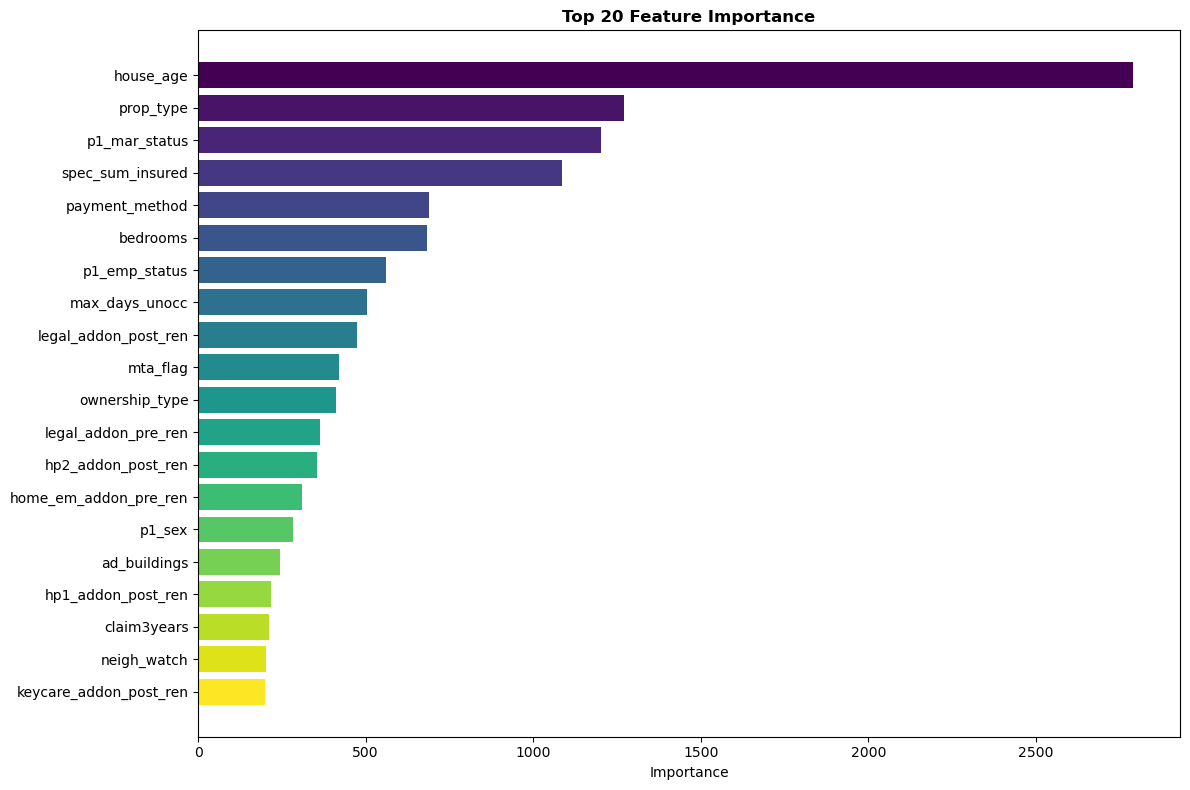

feature,importance,cumulative_importance,cumulative_pct
str,i32,i32,f64
"""house_age""",2791,2791,19.368494
"""prop_type""",1272,4063,28.195697
"""p1_mar_status""",1203,5266,36.544067
"""spec_sum_insured""",1087,6353,44.087439
"""payment_method""",688,7041,48.861901
…,…,…,…
"""subsidence""",45,14336,99.486468
"""contents_cover""",35,14371,99.729355
"""buildings_cover""",20,14391,99.868147


In [10]:
modeling.analyze_feature_importance(lgb, feature_cols)

So the intial tests demonstrate a few things with the model accuracy. Both these baselines are fine. With an ROC being relatively high at ~.75. Which as a first pass is ok. 

However looking at the Prescission and Recall trade offs we start to see something that could lead to buisness concenrs as time goes on. We have a very high false positive rate (~1.18 false positives for every correct positve). This could lead to issues such as irritating customers non churn likely, higher marketing spend, poor investment of staff time trying to retain low risk customers.

Further areas of improvement that can be done from here
- Reduce the class weighting so its no longer so aggressive
- I have set the threshold of f1-score at 50%. If we set that at say 60% this will create more conserative model but will likely reduce the number of false positives. Trade off here will likely be an increased number of false negatives. 
- Improved feature Engineering. Currently I have done none. But creating some synthetic features may help boost the signal
- Change encoing from binary encoding to WOE or Target Encoding on a wider array of features. 

## Feature Generation Work

### Weight of Evidence
Previous work on insurace data made me aware of weight of evidence encoding. While this isn't a directly related to the actuarial calculations that go on under the hood for insurance it feels like a good place to apply it to the categorical variables at least.

In [11]:
def calculate_woe(
    df: pl.DataFrame, 
    feature_col: str, 
    target_col: str,
    total_lapses: int,
    total_non_lapses: int,
    epsilon = 0.5
) -> pl.DataFrame:
    """Calculates WoE and IV for a categorical/binned feature in a Polars DataFrame."""
    

    woe_df = df.group_by(feature_col).agg(
        # Lapsed: target=1; Non-Lapsed: target=0
        pl.col(target_col).sum().alias("lapsed_count"),
        (pl.count() - pl.col(target_col).sum()).alias("non_lapsed_count")
    ).with_columns([
        # Add epsilon for smoothing
        (pl.col("lapsed_count") + epsilon).alias("lapsed_smoothed"),
        (pl.col("non_lapsed_count") + epsilon).alias("non_lapsed_smoothed"),
    ])
    
    # Calculate % Distribution and WoE
    woe_df = woe_df.with_columns([
        # % Distribution
        (pl.col("lapsed_smoothed") / total_lapses).alias("lapsed_perc"),
        (pl.col("non_lapsed_smoothed") / total_non_lapses).alias("non_lapsed_perc"),
    ]).with_columns([
        # WoE calculation
        (pl.col("non_lapsed_perc").log() - pl.col("lapsed_perc").log()).alias(f"WoE_{feature_col}")
    ])
    
    # Calculate Information Value (IV)
    woe_df = woe_df.with_columns([
        ((pl.col("non_lapsed_perc") - pl.col("lapsed_perc")) * pl.col(f"WoE_{feature_col}"))
        .alias(f"IV_{feature_col}")
    ])
    
    # The sum of IV is the total feature IV, which you can calculate separately
    return woe_df.select([
        feature_col, 
        f"WoE_{feature_col}",
        f"IV_{feature_col}"
    ])

In [12]:
target_col = 'lapsed_flag'
categorical_cols = [col for col in dataset.columns 
                       if dataset[col].dtype == pl.Utf8 and col != target_col]
lapses_flag_count= dataset.group_by(target_col).count()
lapses_count = lapses_flag_count.filter(pl.col(target_col) == 1).select(pl.col('count')).item()
non_lapse_count = lapses_flag_count.filter(pl.col(target_col) == 0).select(pl.col('count')).item()

In [13]:
woe_dataset = dataset.__copy__()
iv_totals = {}
woe_cols = []
woe_values = pl.DataFrame()
for col in categorical_cols:
    woe_table = calculate_woe(df=woe_dataset,
                              feature_col=col,target_col=target_col,
                               total_lapses=lapses_count, 
                               total_non_lapses=non_lapse_count)
    iv_total =  round(woe_table.select(pl.col(f'IV_{col}').sum()).item(),2)
    iv_totals[col] = iv_total
    if iv_total>=0.02:
        woe_dataset = woe_dataset.join(woe_table.select([col, f"WoE_{col}"]), on=col)
        first_col = woe_table.columns[0]
        woe_table = (woe_table.drop(woe_table.columns[-1]).with_columns(pl.lit(first_col).alias("variable"))
        .rename({first_col: "var", woe_table.columns[1]: "WoE"}).select(["variable", "var", "WoE"]))
        woe_values = woe_values.vstack(woe_table)
        woe_cols += [ f"WoE_{col}"]
        
    woe_dataset = woe_dataset.drop(col)

woe_values.write_parquet(target_dir/'woe_values.parquet')


In [15]:
woe_values

variable,var,WoE
str,str,f64
"""p1_mar_status""","""W""",-0.047659
"""p1_mar_status""","""M""",-0.349269
"""p1_mar_status""","""D""",-0.231951
"""p1_mar_status""","""C""",-0.333595
"""p1_mar_status""","""P""",0.886645
…,…,…
"""p1_sex""","""F""",0.152109
"""p1_sex""","""N""",-0.201912
"""payment_method""","""PureDD""",0.418764


The IV is useful for filtering out low predictive usefullness of the columns. From googling it looks as though less than 0.02 is a drop and anything else is a keep but with impact levels changing over time. 

Before bucketing the continous variables and then running the WoE encoding on those buckets I am first going to see how this encoding impacts the tree models performance.

Dataset prepared:
  Total samples: 189,005
  Features: 38
  Target distribution:
    Not Lapsed (0): 136,471 (72.2%)
    Lapsed (1): 52,534 (27.8%)
  Imbalance ratio: 2.6:1

Train set: 151,204 samples
  Not Lapsed: 109,177 (72.2%)
  Lapsed: 42,027 (27.8%)

Test set: 37,801 samples
  Not Lapsed: 27,294 (72.2%)
  Lapsed: 10,507 (27.8%)

TRAINING XGBOOST
Using scale_pos_weight=2.60

Running 5-fold CV...
CV AUC: 0.7483 (+/- 0.0032)
✅ Training complete

EVALUATING XGB
  AUC-ROC: 0.7499
  Average Precision: 0.5736
  Threshold: 0.50
                Predicted
                No    Yes
Actual No     19418    7876
       Yes     3708    6799
  Precision: 0.463 (of flagged, % actually lapsed)
  Recall: 0.647 (% of lapses caught)
  F1-Score: 0.540
  Specificity: 0.711

  True Positives: 6,799 (caught lapses)
  False Positives: 7,876 (false alarms)
  False Negatives: 3,708 (missed lapses)
  True Negatives: 19,418
  Optimal threshold (f1): 0.50
  Score at optimal: 0.540
  At 0.50: catch 6799/10507 l

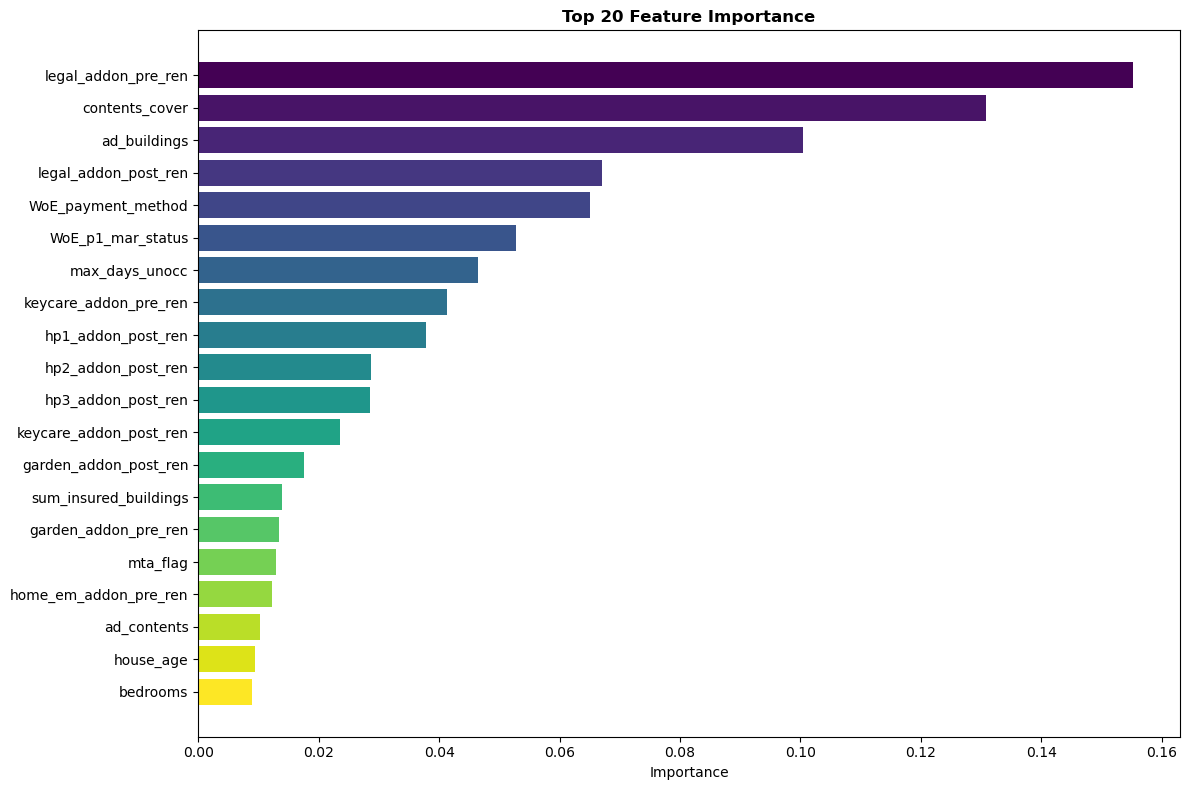

In [17]:
X_train, X_test, y_train, y_test, feature_cols = modeling.prepare_modeling_data(woe_dataset)
xgb_model, evals, features = xgb_pipeline(X_train, y_train, X_test, y_test, weighting)

### Review of WoE
As it Currently stands and only encoding the it Catagorical Variables this has lead to 
- 2 addtional removals from the columns 
- All 3 of these columns are now included in the top 20 variables. 

For full robustness it would be worthwhile encoding the rest of the variables into buckets to allow a full WOE encoding of the variables.

It would also be worth while checking for low % encodings to provide an 'other' flag that will prevent the process breaking when there are new / previously unseen catagories. 

As it stand this model is fine. And works as a good first pass to build an assemsment module out of. 

## Final Model Build
Going with XG-Boost with the top 20 features as determined by the Feature Importance analysis. This gives us a cumulative Feature Importance of 88%

In [18]:
final_feature_list = features.head(20).get_column('feature').to_list()
features.head(20).get_column('cumulative_pct').to_list()[-1]

87.6379623413086

In [19]:
final_feature_list += [target_col]

In [20]:
final_data_set = woe_dataset.select(final_feature_list)

In [21]:
X_train, X_test, y_train, y_test, feature_cols = modeling.prepare_modeling_data(final_data_set)
xgb = modeling.train_xgboost(X_train, y_train, weighting, use_cv=True, random_state=42)

Dataset prepared:
  Total samples: 189,005
  Features: 20
  Target distribution:
    Not Lapsed (0): 136,471 (72.2%)
    Lapsed (1): 52,534 (27.8%)
  Imbalance ratio: 2.6:1

Train set: 151,204 samples
  Not Lapsed: 109,177 (72.2%)
  Lapsed: 42,027 (27.8%)

Test set: 37,801 samples
  Not Lapsed: 27,294 (72.2%)
  Lapsed: 10,507 (27.8%)

TRAINING XGBOOST
Using scale_pos_weight=2.60

Running 5-fold CV...
CV AUC: 0.7469 (+/- 0.0040)
✅ Training complete


In [ ]:
model_filename = 'xgb_modle.json'
model_path = target_dir/model_filename
xgb.get_booster().feature_names = final_feature_list[:-1]
xgb.save_model(model_path)

# Save the training data splits

